<div style="display: flex; align-items: center;">
    <img src="photos\telecom_logo.png" width="80">
    <h2 style="margin-left: 10px;">Proyecto de servicios interconnect</h2>
</div>
<p>Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos</p>



#### Objetivo

Métrica principal: AUC-ROC.

Métrica adicional: exactitud.

Criterios de evaluación:

- AUC-ROC < 0.75 — 0 SP
- 0.75 ≤ AUC-ROC < 0.81 — 4 SP
- 0.81 ≤ AUC-ROC < 0.85 — 4.5 SP
- 0.85 ≤ AUC-ROC < 0.87 — 5 SP
- 0.87 ≤ AUC-ROC < 0.88 — 5.5 SP
- AUC-ROC ≥ 0.88 — 6 SP

# Análisis exploratorio de los datos (EDA)
<p>Es importante obtener una visión general de los datos proporcionados por el cliente, analizando su estructura y buscando posibles relaciones que puedan estar vinculadas al problema en cuestión. A medida que avanzamos, debemos identificar patrones, reconocer correlaciones entre las variables y determinar el enfoque adecuado para manejar los datos faltantes y los valores atípicos. Finalmente, debemos extraer conclusiones basadas en el análisis realizado, lo que nos permitirá tomar decisiones informadas para abordar el problema de manera efectiva.</p>

In [1]:
#libraries to EDA 
import pandas as pd
import numpy as np
from functools import reduce
import scipy.stats as stats
#libraries to visualitation data
import matplotlib.pyplot as plt
import seaborn as sns
#Libraries to machine learning model 
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from xgboost import XGBClassifier
#Library to hiperparameters tuning 
import optuna

# 1. Limpieza de datos
<p>Comenzamos cargando el conjunto de datos desde un archivo CSV y observamos las primeras filas de cada dataframe.</p>

In [2]:
# load csv files
df_contract = pd.read_csv('final_provider/contract.csv')
df_internet = pd.read_csv('final_provider/internet.csv')
df_personal = pd.read_csv('final_provider/personal.csv')
df_phone = pd.read_csv('final_provider/phone.csv')

In [3]:
#data frame information 
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [4]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [5]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [6]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Podemos encontrar relacion en cada dataframe por medio de ID "custumerID", se pueden observar que la cantidad de filas no son los mismos. De igual forma, los tipos de datos no tienen relación con su información por lo que se tendrá que solucionar para poder hacer la prueba de correlación 

In [7]:
# Data correction based on the information from each DataFrame  
def columns_format(df1,df2,df3,df4):
    """
    df1, df2, df3, df4: Values from each DataFrame.  
    Columns were corrected based on their data types.  
    df_merge: Represents the merged information from all DataFrames.  
    """
    
    dfs = [df1,df2,df3,df4]     
    for df in [df1, df2, df3, df4]:
        df.columns = df.columns.str.lower()
        
    df1['begindate'] = pd.to_datetime(df1['begindate'], errors='coerce')
    df1['year'] = df1['begindate'].dt.year
    df1['month'] = df1['begindate'].dt.month
    df1['totalcharges'] = pd.to_numeric(df1['totalcharges'], errors='coerce')
    df1['target'] = np.where(df1['enddate'] != 'No', 1, 0)   
    df3['seniorcitizen'] = pd.to_numeric(df3['seniorcitizen'], errors='coerce')
    df3['seniorcitizen'] = np.where(df3['seniorcitizen'] > 0, 'Yes', 'No')  
    dfs = [df1, df2, df3, df4]

    df_merge = reduce(lambda left, right: pd.merge(left, right, on='customerid', how='left'), dfs)

    return df_merge

In [8]:
df_merge = columns_format(df_contract,df_internet,df_personal,df_phone)

In [30]:
#Data frame merge
df_merge.head(10)

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,year,month,...,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,gender,seniorcitizen,partner,dependents,multiplelines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,2020,1,...,Yes,No,No,No,No,Female,No,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,2017,4,...,No,Yes,No,No,No,Male,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,2019,10,...,Yes,No,No,No,No,Male,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,2016,5,...,No,Yes,Yes,No,No,Male,No,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,2019,9,...,No,No,No,No,No,Female,No,No,No,No
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.50,2019,3,...,No,Yes,No,Yes,Yes,Female,No,No,No,Yes
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,2018,4,...,Yes,No,No,Yes,No,Male,No,No,Yes,Yes
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.90,2019,4,...,No,No,No,No,No,Female,No,No,No,NaN
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05,2017,7,...,No,Yes,Yes,Yes,Yes,Female,No,Yes,No,Yes
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95,2014,12,...,Yes,No,No,No,No,Male,No,No,Yes,No


Valores nulos debido a que no se recolectaron la misma cantidad de datos conforme al numero total de filas

In [10]:
#Revise null values from each column
df_merge.isnull().sum()

customerid             0
begindate              0
enddate                0
type                   0
paperlessbilling       0
paymentmethod          0
monthlycharges         0
totalcharges          11
year                   0
month                  0
target                 0
internetservice     1526
onlinesecurity      1526
onlinebackup        1526
deviceprotection    1526
techsupport         1526
streamingtv         1526
streamingmovies     1526
gender                 0
seniorcitizen          0
partner                0
dependents             0
multiplelines        682
dtype: int64

Explicación estadistica de los valores númericos.
- Los valores de "TotalCharges" presentan una desviación estándar elevada, lo que indica una alta dispersión respecto a la media. Esto sugiere la posible presencia de valores atípicos situados por encima del promedio, los cuales podrían influir en el análisis y requerir una evaluación más detallada.

In [11]:
#Information on every numeric column 
df_merge.describe()

,begindate,monthlycharges,totalcharges,year,month,target
count,7043,7043.000000,7032.000000,7043.000000,7043.000000,7043.000000
mean,2017-04-30 13:01:50.918642688,64.761692,2283.300441,2016.878603,6.421269,0.265370
min,2013-10-01 00:00:00,18.250000,18.800000,2013.000000,1.000000,0.000000
25%,2015-06-01 00:00:00,35.500000,401.450000,2015.000000,3.000000,0.000000
50%,2017-09-01 00:00:00,70.350000,1397.475000,2017.000000,6.000000,0.000000
75%,2019-04-01 00:00:00,89.850000,3794.737500,2019.000000,10.000000,1.000000
max,2020-02-01 00:00:00,118.750000,8684.800000,2020.000000,12.000000,1.000000
std,NaN,30.090047,2266.771362,1.970573,3.578453,0.441561


<h3 id="Prueba-de-correlacion">2. Correlación entre Variables</h3>
<p>El análisis de correlación entre columnas categóricas y numéricas busca identificar relaciones significativas que puedan influir en la variable objetivo. Esto permite detectar patrones y dependencias que podrían impactar el modelo, facilitando la selección de características relevantes para el análisis.</p>

In [12]:
def correlation_matrix(df_merge):
    df_copy = df_merge.copy()  # Evitar modificar el DataFrame original

    # Convertir columnas 'Yes'/'No' a 1/0
    for col in df_copy.columns:
        if set(df_copy[col].dropna().unique()).issubset({'Yes', 'No'}):
           df_copy[col] = df_copy[col].replace({'Yes': 1, 'No': 0})        

    # Seleccionar solo las columnas numéricas para la matriz de correlación
    df_num = df_copy.select_dtypes(include='number')
    corr_matrix = df_num.corr()

    # Crear la figura correctamente
    plt.figure(figsize=(20, 16))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Matriz de correlación')
    plt.show()
    
    return df_copy

C:\Users\Asus\AppData\Local\Temp\ipykernel_9476\1788345062.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy[col] = df_copy[col].replace({'Yes': 1, 'No': 0})


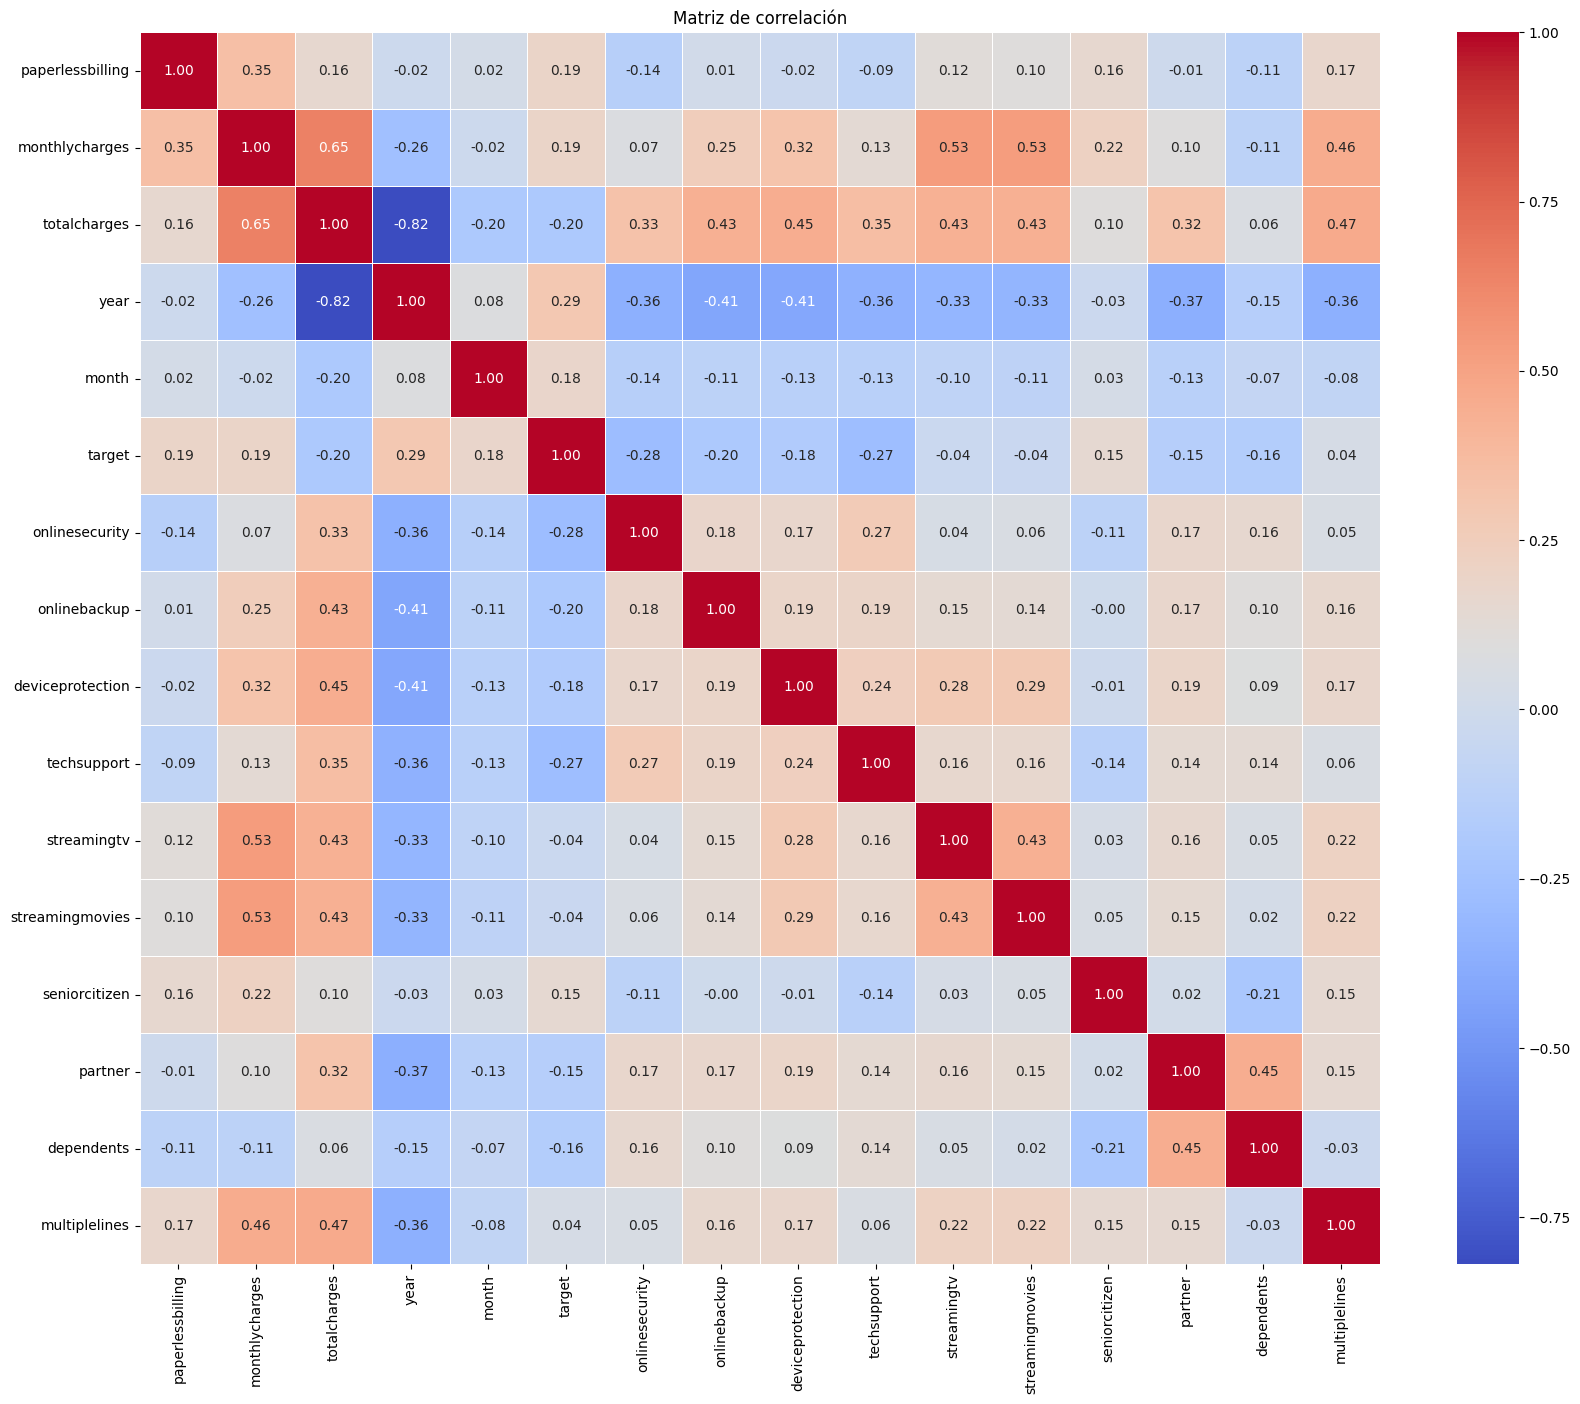

In [13]:
df_transformed = correlation_matrix(df_merge)

Se puede observar una matriz estable con las siguientes relaciones y encontrar si hay columnas que no aportan nada al modelo:
- Correlación alta entre "monthlycharges" y "totalcharges", maneja congruencia ya que a medida que los precios mensuales son altos el precio total igual. No hay contradicción.
- Correlacion moderada entre "paperlessbilling", "totalcharges", "monthlycharges", y "year" con la columna objetivo.

### 3. Hipotesis nula
Comprobar si la columna "paperlessbilling" es causa de la cancelacion de servicios

In [14]:
tabla_contingencia = pd.crosstab(df_transformed['paperlessbilling'], df_transformed['target'])

chi2, p, dof, expected = stats.chi2_contingency(tabla_contingencia)

print(f"Estadístico Chi-cuadrado: {chi2:.4f}")
print(f"Valor p: {p:.4f}")

# Interpretación
alpha = 0.05  # Nivel de significancia
if p < alpha:
    print("Rechazamos la hipótesis nula: La recepción de la factura afecta la cancelación.")
else:
    print("No hay suficiente evidencia para rechazar la hipótesis nula.")

Estadístico Chi-cuadrado: 258.2776
Valor p: 0.0000
Rechazamos la hipótesis nula: La recepción de la factura afecta la cancelación.


C:\Users\Asus\AppData\Local\Temp\ipykernel_9476\3348719406.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=df_transformed['paperlessbilling'], y=df_transformed['target'], ci=None)


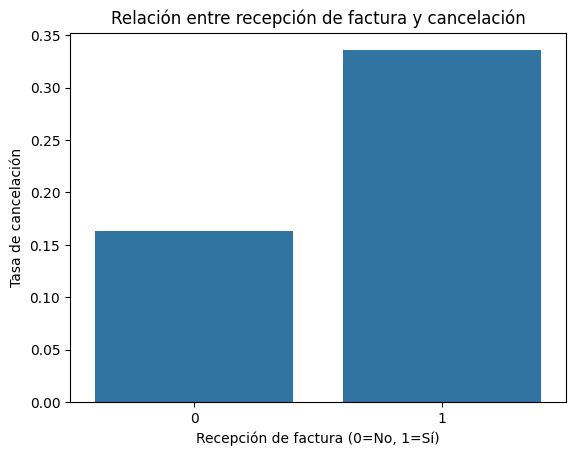

In [15]:
sns.barplot(x=df_transformed['paperlessbilling'], y=df_transformed['target'], ci=None)
plt.xlabel("Recepción de factura (0=No, 1=Sí)")
plt.ylabel("Tasa de cancelación")
plt.title("Relación entre recepción de factura y cancelación")
plt.show()

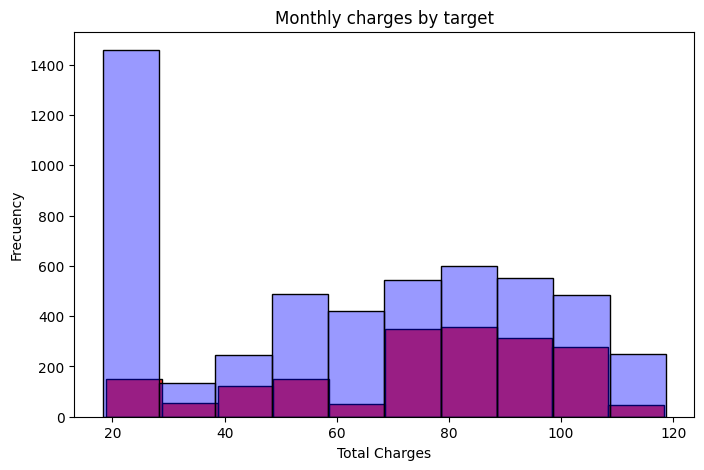

In [ ]:
plt.figure(figsize=(8, 5))
charges_target0 = df_merge[df_merge['target']== 0]
charges_target1 = df_merge[df_merge['target']== 1]

sns.histplot(charges_target1['monthlycharges'], bins=10, kde=False, color='red', fill=True,alpha=0.8)
sns.histplot(charges_target0['monthlycharges'], bins=10, kde=False, color='blue',fill=True,alpha=0.4
             )
plt.title('Histogram Monthly charges by target')
plt.xlabel('Total Charges')
plt.ylabel('Frecuency')
# Show histogram
plt.show()

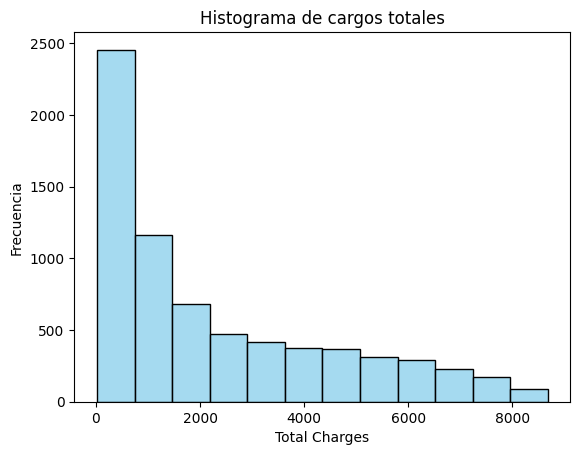

In [17]:
sns.histplot(df_merge['totalcharges'], bins=12, kde=False, color='skyblue', edgecolor='black')
plt.title('Histograma de cargos totales')
plt.xlabel('Total Charges')
plt.ylabel('Frecuencia')
plt.show()

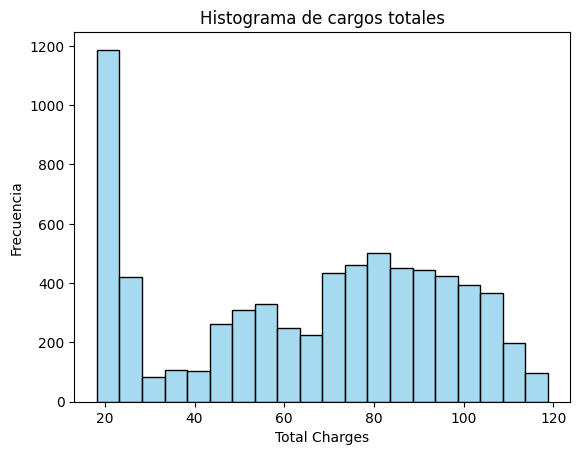

In [18]:
sns.histplot(df_merge['monthlycharges'], bins=20, kde=False, color='skyblue', edgecolor='black')
plt.title('Histograma de cargos totales')
plt.xlabel('Total Charges')
plt.ylabel('Frecuencia')
plt.show()

C:\Users\Asus\AppData\Local\Temp\ipykernel_9476\2874845875.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='internetservice', y='monthlycharges', data=df_merge, palette="Pastel1")


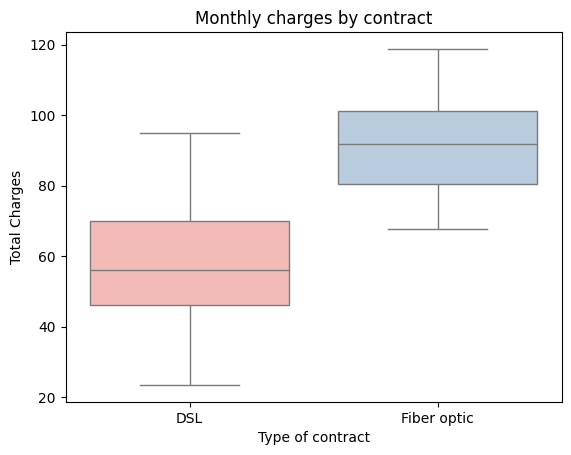

In [19]:
sns.boxplot(x='internetservice', y='monthlycharges', data=df_merge, palette="Pastel1")
plt.title("Monthly charges by contract")
plt.xlabel("Type of contract")
plt.ylabel("Total Charges")
plt.show()

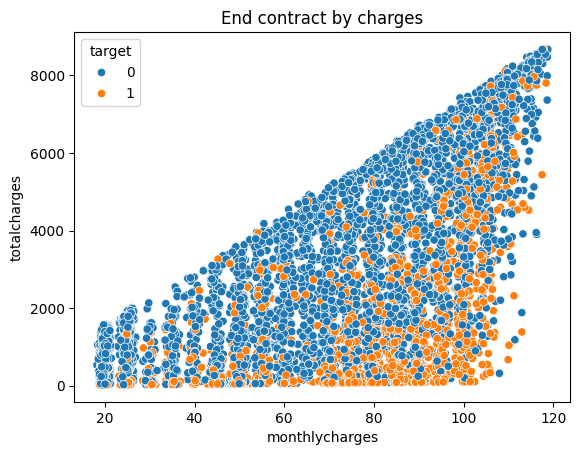

In [20]:
sns.scatterplot(x='monthlycharges', y='totalcharges', hue='target', data=df_merge)
plt.title('End contract by charges')
plt.show()
plt.show()

### Conclusiones del analisis
Con base en el análisis de correlación y otras técnicas exploratorias, podemos interpretar que una de las principales razones por las cuales los clientes cancelan su servicio está relacionada con los incrementos en los gastos mensuales ("monthlycharges"), especialmente en aquellos clientes con mayor antigüedad en el servicio ("begindate").

Además, los clientes que no utilizan facturación electrónica ("paperlessbilling" = 0) presentan una tasa de cancelación más baja en comparación con aquellos que sí la usan, quienes muestran una tasa de cancelación superior al 30%.

🔹 Posibles causas de cancelación:
1️⃣ Aumentos recurrentes en los costos del servicio → Los clientes podrían percibir incrementos en su factura mes a mes, lo que influye en su decisión de cancelar.
2️⃣ Facturación como recordatorio → Al recibir la factura, algunos clientes pueden recordar pagos atrasados y optar por cancelar el servicio en lugar de regularizar su situación.
3️⃣ Errores en la facturación → Problemas con la facturación electrónica podrían generar confusión o frustración, impulsando la cancelación del servicio.

In [21]:
"""
Function preprocess_data_with_imputation

This function splits the dataset into training, testing, and validation sets (80%-10%-10%) and preprocesses the data as follows:
Missing data are impute using Knn_imputer
Categorical features are transformed using One-Hot Encoding.
Numerical features are standardized using Standard Scaler.
Data split:

Training set: 80% of the total dataset.
Test set: 10% of the total dataset.
Validation set: 10% of the total dataset
"""
def preprocess_data_with_imputation(df, n_neighbors=5, random_state=42):
    """
    Parameters:
    X (pd.DataFrame): Features
    y (pd.Series): Target
    n_neighbors (int): neighbors to KNNImputer
    random_state (int): random seed
    """
    try:
        X = df.drop(columns=['customerid','begindate','enddate','target','paymentmethod'],axis=1)
        y = df['target']
        
        # 1. Split inicial
        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y, 
            test_size=0.2,  # 10% test + 10% validation
            random_state=random_state
        )
        
        # 2. Split validation
        X_test, X_val, y_test, y_val = train_test_split(
            X_temp, y_temp,
            test_size=0.5,  # Mitad de 20% = 10%
            random_state=random_state
        )
        
        # 3. Identificar tipos de columnas
        cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
        num_cols = X_train.select_dtypes(include="number").columns.tolist()

        # 4. Pipelines
        cat_transformer = Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
        ])

        num_transformer = Pipeline([
            ("knn_imputer", KNNImputer(n_neighbors=n_neighbors)),
            ("scaler", StandardScaler()),
        ])

        # 5. ColumnTransformer
        preprocessor = ColumnTransformer([
            ("cat", cat_transformer, cat_cols),
            ("num", num_transformer, num_cols)
        ], remainder="passthrough")
        

        # 6. Aplicar transformaciones
        X_train_processed = preprocessor.fit_transform(X_train)
        X_test_processed = preprocessor.transform(X_test)
        X_val_processed = preprocessor.transform(X_val)
        
        
        return X_train_processed, y_train, X_test_processed, y_test, X_val_processed, y_val, preprocessor

        
    except Exception as e:
        print(f"Error crítico: {str(e)}")
        print("Revisa:")
        print("- Tipos de datos en columnas (categóricas deben ser object/category)")
        print("- Columnas con todos los valores faltantes")
        print("- Consistencia entre X e y")
        return None, None, None, None

In [22]:
#Output funtion
X_train, y_train, X_test, y_test, X_val, y_val, preprocessor = preprocess_data_with_imputation(df_merge, n_neighbors=5)

In [23]:
# This function tunes hyperparameters to find the best configuration for the model.  
def objective(trial):  
    """  
    Optimizes the hyperparameters of a Random Forest model  
    to achieve the best performance based on a selected metric.  
    """  
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1500),
        'max_depth': trial.suggest_int('max_depth', 15, 35),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': True,
        'class_weight': 'balanced'
    } 
    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, preds)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2025-02-14 00:28:28,470] A new study created in memory with name: no-name-1d9c272f-e19e-487b-83ff-0bc3eecf12e8
[I 2025-02-14 00:28:33,598] Trial 0 finished with value: 0.8830356126976903 and parameters: {'n_estimators': 817, 'max_depth': 25, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8830356126976903.
[I 2025-02-14 00:28:39,322] Trial 1 finished with value: 0.882104696986936 and parameters: {'n_estimators': 902, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.8830356126976903.
[I 2025-02-14 00:28:46,170] Trial 2 finished with value: 0.8825804983502105 and parameters: {'n_estimators': 1052, 'max_depth': 31, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.8830356126976903.
[I 2025-02-14 00:28:55,564] Trial 3 finished with value: 0.8832217958398412 and parameters: {'n_estimators': 1401, 'max_depth': 32, '

In [24]:
best_params_rf = study.best_trial.params
model_rf= RandomForestClassifier(**best_params_rf)
model_rf.fit(X_train, y_train)


y_probs = model_rf.predict_proba(X_test)[:,1]

y_pred = model_rf.predict(X_test)


print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_probs))

Accuracy Score: 0.8451704545454546
AUC-ROC: 0.8831080172529713


In [25]:
def objective(trial):
    params = {
        'C': trial.suggest_float('C', 0.001, 10, log=True),  # Regularización inversa
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']),  # Soporta L1/L2
        'max_iter': trial.suggest_int('max_iter', 500, 2000)  # Para convergencia
    }
    model = LogisticRegression(**params, class_weight='balanced')
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, preds)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2025-02-14 00:30:42,632] A new study created in memory with name: no-name-b01ed182-d8be-4953-8d72-aeca63c6a071
[I 2025-02-14 00:30:42,711] Trial 0 finished with value: 0.7936004716639602 and parameters: {'C': 0.0023598009307865707, 'penalty': 'l1', 'solver': 'saga', 'max_iter': 546}. Best is trial 0 with value: 0.7936004716639602.
[I 2025-02-14 00:30:42,791] Trial 1 finished with value: 0.7701310522450584 and parameters: {'C': 0.0021400728210159174, 'penalty': 'l1', 'solver': 'saga', 'max_iter': 868}. Best is trial 0 with value: 0.7936004716639602.
[I 2025-02-14 00:30:43,281] Trial 2 finished with value: 0.8496984867447945 and parameters: {'C': 2.8274800577540518, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 1355}. Best is trial 2 with value: 0.8496984867447945.
[I 2025-02-14 00:30:43,305] Trial 3 finished with value: 0.8496881432368973 and parameters: {'C': 3.042044285986189, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 1814}. Best is trial 2 with value: 0.84969848674

In [26]:
best_params_lr = study.best_trial.params
model_lr= LogisticRegression(**best_params_lr)
model_lr.fit(X_train, y_train)

# Evaluar
lr_pred = model_lr.predict(X_test)
lr_probs = model_lr.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, lr_pred))
print("AUC-ROC:",roc_auc_score(y_test,lr_probs))

Accuracy: 0.8039772727272727
AUC-ROC: 0.8522119591638309


In [27]:
def objective(trial):
    params = {
        "lambda": trial.suggest_float("lambda", 1e-3, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-3, 10.0, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0.5, 10),
        "n_estimators": 100
    }

    model = XGBClassifier(**params)

    # `early_stopping_rounds` ahora se maneja con `model.set_params`
    model.set_params(early_stopping_rounds=10)

    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )
    preds = model.predict(X_test)
    return accuracy_score(y_test, preds)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=150)

[I 2025-02-14 00:30:47,744] A new study created in memory with name: no-name-9bd1c2e9-35ab-4dd6-a41a-ad8af137ea41
[I 2025-02-14 00:30:48,253] Trial 0 finished with value: 0.8494318181818182 and parameters: {'lambda': 0.015122421142717203, 'alpha': 0.002960271278903229, 'max_depth': 10, 'learning_rate': 0.06409317907208868, 'subsample': 0.9645350645602064, 'colsample_bytree': 0.9660918021535028, 'min_child_weight': 3, 'scale_pos_weight': 6.657154958058873}. Best is trial 0 with value: 0.8494318181818182.
[I 2025-02-14 00:30:48,504] Trial 1 finished with value: 0.6903409090909091 and parameters: {'lambda': 0.005457806856353286, 'alpha': 4.707820605711454, 'max_depth': 8, 'learning_rate': 0.022168179479672714, 'subsample': 0.5222151654247216, 'colsample_bytree': 0.7071816306753831, 'min_child_weight': 10, 'scale_pos_weight': 5.126551178535846}. Best is trial 0 with value: 0.8494318181818182.
[I 2025-02-14 00:30:48,787] Trial 2 finished with value: 0.734375 and parameters: {'lambda': 0.957

In [28]:
best_params_xgb = study.best_trial.params
model_xgb = XGBClassifier(
    **best_params_xgb
)

model_xgb.fit(X_train, y_train)

# Evaluar
xgb_pred = model_xgb.predict(X_test)
xgb_probs = model_xgb.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, xgb_pred))
print("AUC-ROC:",roc_auc_score(y_test, xgb_probs))

Accuracy: 0.9019886363636364
AUC-ROC: 0.9287435740957188


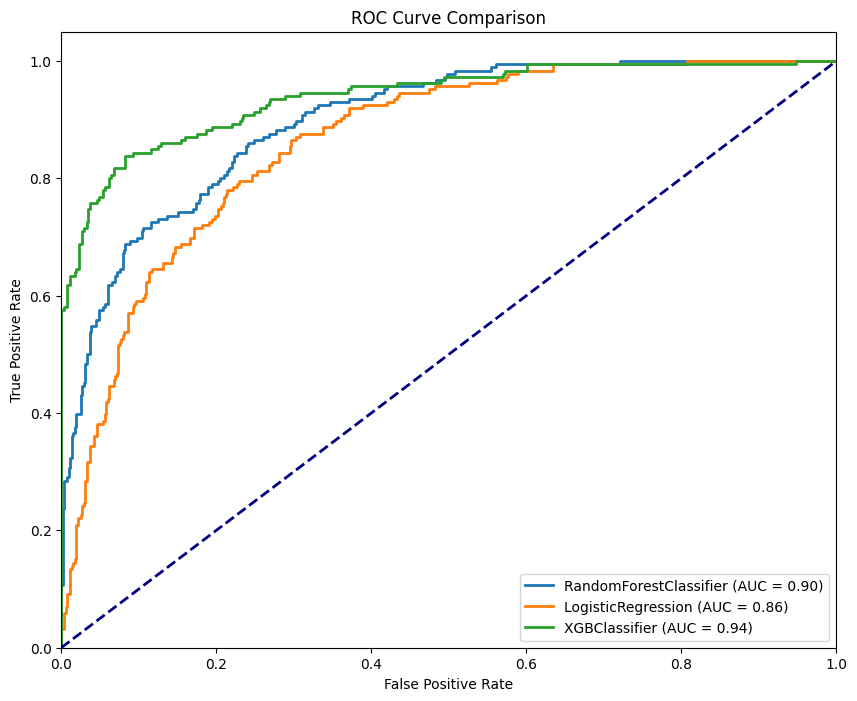

RandomForestClassifier: AUC - ROC = 0.90
LogisticRegression: AUC - ROC = 0.86
XGBClassifier: AUC - ROC = 0.94


In [29]:
models = {
    'RandomForestClassifier': model_rf,
    'LogisticRegression': model_lr,
    'XGBClassifier': model_xgb
}

# Initialize a dictionary to store AUC - ROC scores
roc_auc_scores = {}

# Plot the ROC curves
plt.figure(figsize=(10, 8))

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict the probabilities
    y_probs = model.predict_proba(X_val)[:, 1]
    
    # Calculate the AUC - ROC score
    roc_auc = roc_auc_score(y_val, y_probs)
    roc_auc_scores[name] = roc_auc
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_val, y_probs)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()

# Print the AUC - ROC scores for each model
for name, score in roc_auc_scores.items():
    print(f'{name}: AUC - ROC = {score:.2f}')

<h2 id="Resultados">Resultados</h2>
<p>El modelo XGBClassifier mostró un rendimiento sobresaliente, alcanzando una precisión del 94% en los datos de validación. Su capacidad de escalabilidad le permite mantener un alto nivel de precisión incluso al trabajar con volúmenes de datos más grandes, lo que lo convierte en una opción robusta para realizar predicciones en entornos de mayor complejidad. 

Acontinuación presento una tabla comparativa entre los dos mejores modelos.</p>

|Característica|Bosque aleatorio|XGBoost|
|--------------|----------------|-------|
|Construcción de modelos| Aprendizaje conjunto utilizando árboles de decisiones construidos independientemente.   | Aprendizaje conjunto secuencial con árboles que corrigen errores de los anteriores.    |
| Enfoque de optimización    | Realiza predicciones promediando las salidas de árboles individuales.   | Emplea el aumento de gradiente para minimizar una función de pérdida y mejorar la precisión de forma iterativa.|
| Manejo de conjuntos de datos no balanceados| Puede resultar un poco complicado| Lo maneja como un profesional|
|Precisión predictiva|Bueno, pero no siempre el más preciso|Precisión superior, especialmente en situaciones difíciles|




	








## Limitaciones
A lo largo del análisis, surgieron desafíos en el manejo de datos faltantes, lo que hizo necesario aplicar técnicas de imputación para preservar la calidad del dataset. Además, la falta de claridad en los datos representó una de las principales dificultades para mejorar la precisión del modelo. Para abordar estos problemas, se utilizó KNN Imputer, una herramienta eficaz para estimar valores ausentes sin introducir ruido ni aumentar el riesgo de sobreajuste (overfitting), asegurando así la integridad y representatividad de los datos en el modelo.